### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [119]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [120]:
var_name = 'OMEGA'
sat_var = 2

In [121]:
Paras = {
     'M0':['M0'],
    'e':['OMEGA','i0','omega','I_dot','Cus','Crs','e' , 'M0'],
    'sqrt_A':['Cuc','Crc','Del_n','Crs','sqrt_A','OMEGA_dot','Cus'],
    'OMEGA':['OMEGA'],
    'i0':['e','i0','omega','OMEGA' ,'I_dot'],
    'omega':['omega','e','OMEGA','i0'],
    'I_dot':['I_dot','e','Crs','Cuc'],
    'Cic':['M0','Cic'],
    'Cis':['Cis'],
    'OMEGA_dot':['OMEGA_dot','sqrt_A','Crc','Del_n','Cus' , 'omega' ],
    'Cuc':['Cuc','e','sqrt_A','I_dot','Crs'],
    'Cus':['Cus','sqrt_A','OMEGA_dot','Crc','Del_n','Cus'],
    'Crc':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Crs':['Crs','e','sqrt_A','I_dot','Cuc'],
    'Del_n':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Codes' : ['Codes']    
}

In [122]:
df = pd.read_csv("hourinterpol_21.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
#df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A'  ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
#       'Del_n', 'Cuc','Cus','Toe', 'Cic', 
#       'Cis', 'Crc', 'M0', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
#       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
#       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df = df.loc[:,Paras[var_name]]
#df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslib.Timestamp'>


,OMEGA
Epoch_Time_of_Clock,
2017-11-02 00:00:00,0.95248002769999995376
2017-11-02 01:00:00,0.95244792620000007233
2017-11-02 02:00:00,0.95241575769999997636
2017-11-02 03:00:00,0.95238353279999998779
2017-11-02 04:00:00,0.95235128089999998569


In [123]:
test = df.iloc[265:408,:]
test

,OMEGA
Epoch_Time_of_Clock,
2017-11-13 01:00:00,0.70421443110000003784
2017-11-13 02:00:00,0.70394055980000003192
2017-11-13 03:00:00,0.70374527319999991004
2017-11-13 04:00:00,0.70364920340000003396
2017-11-13 05:00:00,0.70362802829999993026
2017-11-13 06:00:00,0.70361435810000005908
2017-11-13 07:00:00,0.70358225580000000043
2017-11-13 08:00:00,0.70354865970000002307
2017-11-13 09:00:00,0.70352016319999988170


In [124]:
#df.head(7)

In [125]:
df.columns

Index(['OMEGA'], dtype='object')

# Enter number of entries per day

In [126]:
'''entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))'''
valid_start_dt = '2017-11-07 00:00:00'
test_start_dt = '2017-11-10 00:00:00'


Load data into Pandas dataframe

# enter lag and no. of outputs

In [127]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 24
HORIZON = 24

Create training set containing only the model features

In [128]:
train = df.copy()[df.index < valid_start_dt][Paras[var_name]]
train.head()

,OMEGA
Epoch_Time_of_Clock,
2017-11-02 00:00:00,0.95248002769999995376
2017-11-02 01:00:00,0.95244792620000007233
2017-11-02 02:00:00,0.95241575769999997636
2017-11-02 03:00:00,0.95238353279999998779
2017-11-02 04:00:00,0.95235128089999998569


In [129]:
train.tail(6)

,OMEGA
Epoch_Time_of_Clock,
2017-11-06 18:00:00,0.82864178239999997100
2017-11-06 19:00:00,0.82861265739999989677
2017-11-06 20:00:00,0.82858356950000000563
2017-11-06 21:00:00,0.82855451189999995698
2017-11-06 22:00:00,0.82852547769999995708
2017-11-06 23:00:00,0.82849645999999999013


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [130]:
from sklearn.preprocessing import StandardScaler



y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[Paras[var_name]] = X_scaler.fit_transform(train)

In [131]:
import pickle
file_x = open(var_name+'X_scaler2_5D.pkl','wb')
pickle.dump(X_scaler, file_x)
            
file_y = open(var_name+'y_scalar2_5D.pkl','wb')
pickle.dump(y_scalar, file_y)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [132]:
tensor_structure = {'X':(range(-T+1, 1), Paras[var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), Paras[var_name])} ,freq = None)

In [133]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00  0.41068853738134974973  0.41027511905426594652   
2017-11-03 00:00:00  0.41027511905426594652  0.40986111404696706773   
2017-11-03 01:00:00  0.40986111404696706773  0.40944666024881881672   
2017-11-03 02:00:00  0.40944666024881881672  0.40903213750598765852   
2017-11-03 03:00:00  0.40903213750598765852  0.40862342692989056525   
2017-11-03 04:00:00  0.40862342692989056525  0.40823132421697527761   
2017-11-03 05:00:00  0.40823132421697527761  0.40785329922751406562   
2017-11-03 06:00:00  0.40785329922751406562  0.40747383940817172299   
2017-11-03 07:00:00  0.40747383940817172299  0.40709023640372554720   
2017-11-03 08:00:00  0.40709023640372554720  0.40671222702438214469   
2017-11-03 09:00:00  0.40671222702438214469  0.40632832742771984869   
2017-11-03 10:00:00  0.40632832742771984869  0.40590619475306516373   
2017-11-03 11:00:00  0.40590619475306516373  0.40543423458633698342   
2017-11-03 12:00:00  0.40543423458633698342  0.40492254927463650072   
2017-11-03 13:00:00  0.40492254927463650072  0.40438218167459649699   
2017-11-03 14:00:00  0.40438218167459649699  0.40382417594367997493   
2017-11-03 15:00:00  0.40382417594367997493  0.40325957754020158585   
2017-11-03 16:00:00  0.40325957754020158585  0.40269942801994529358   
2017-11-03 17:00:00  0.40269942801994529358  0.40215477414206457496   
2017-11-03 18:00:00  0.40215477414206457496  0.40163665746234045173   
2017-11-03 19:00:00  0.40163665746234045173  0.40115612343909057280   
2017-11-03 20:00:00  0.40115612343909057280  0.40072421753062242855   
2017-11-03 21:00:00  0.40072421753062242855  0.40035198129271987177   
2017-11-03 22:00:00  0.40035198129271987177  0.40005045888285306610   
2017-11-03 23:00:00  0.40005045888285306610  0.39983069706017848599   
2017-11-04 00:00:00  0.39983069706017848599  0.39970373738047565437   
2017-11-04 01:00:00  0.39970373738047565437  0.39968062530205927807   
2017-11-04 02:00:00  0.39968062530205927807  0.39975309656905111400   
2017-11-04 03:00:00  0.39975309656905111400  0.39946882593967569797   
2017-11-04 04:00:00  0.39946882593967569797  0.39803918382089470418   
...                                     ...                     ...   
2017-11-04 18:00:00  2.13719973190660450513  2.34007786454393151843   
2017-11-04 19:00:00  2.34007786454393151843  2.47550416577220033787   
2017-11-04 20:00:00  2.47550416577220033787  2.52434727348756693388   
2017-11-04 21:00:00  2.52434727348756693388  2.46747583078955745606   
2017-11-04 22:00:00  2.46747583078955745606  2.28575847427347955687   
2017-11-04 23:00:00  2.28575847427347955687  1.96006384573802283633   
2017-11-05 00:00:00  1.96006384573802283633  1.47126058438018314511   
2017-11-05 01:00:00  1.47126058438018314511  0.80021732939695655595   
2017-11-05 02:00:00  0.80021732939695655595 -0.06245623686451846901   
2017-11-05 03:00:00 -0.06245623686451846901 -0.90210644610811652200   
2017-11-05 04:00:00 -0.90210644610811652200 -1.29843092805694126923   
2017-11-05 05:00:00 -1.29843092805694126923 -1.24447772250253740900   
2017-11-05 06:00:00 -1.24447772250253740900 -1.14494069099969442149   
2017-11-05 07:00:00 -1.14494069099969442149 -1.15965961430157604717   
2017-11-05 08:00:00 -1.15965961430157604717 -1.18813668294682961424   
2017-11-05 09:00:00 -1.18813668294682961424 -1.18539927209265760766   
2017-11-05 10:00:00 -1.18539927209265760766 -1.17292048247084124135   
2017-11-05 11:00:00 -1.17292048247084124135 -1.16300841878615357494   
2017-11-05 12:00:00 -1.16300841878615357494 -1.15589441255933311758   
2017-11-05 13:00:00 -1.15589441255933311758 -1.15128471521856012849   
2017-11-05 14:00:00 -1.15128471521856012849 -1.14888558209454916259   
2017-11-05 15:00:00 -1.1

In [134]:
train_inputs['target'].shape

(73, 24)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [135]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][Paras[var_name]]
valid[Paras[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -1.19321934080263325484 -1.19359671276888268387   
2017-11-07 01:00:00 -1.19359671276888268387 -1.19397422782787065998   
2017-11-07 02:00:00 -1.19397422782787065998 -1.19435183264502753353   
2017-11-07 03:00:00 -1.19435183264502753353 -1.19472613202000155219   
2017-11-07 04:00:00 -1.19472613202000155219 -1.19509063604683274384   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -1.19397422782787065998 -1.19435183264502753353   
2017-11-07 01:00:00 -1.19435183264502753353 -1.19472613202000155219   
2017-11-07 02:00:00 -1.19472613202000155219 -1.19509063604683274384   
2017-11-07 03:00:00 -1.19509063604683274384 -1.19544422079712497897   
2017-11-07 04:00:00 -1.19544422079712497897 -1.19579139759456909431   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -1.19472613202000155219 -1.19509063604683274384   
2017-11-07 01:00:00 -1.19509063604683274384 -1.19544422079712497897   
2017-11-07 02:00:00 -1.19544422079712497897 -1.19579139759456909431   
2017-11-07 03:00:00 -1.19579139759456909431 -1.19613973604485490654   
2017-11-07 04:00:00 -1.19613973604485490654 -1.19649923572848315700   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -1.19544422079712497897 -1.19579139759456909431   
2017-11-07 01:00:00 -1.19579139759456909431 -1.19613973604485490654   
2017-11-07 02:00:00 -1.19613973604485490654 -1.19649923572848315700   
2017-11-07 03:00:00 -1.19649923572848315700 -1.19687111683623337299   
2017-11-07 04:00:00 -1.19687111683623337299 -1.19724786049529274834   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -1.19613973604485490654 -1.19649923572848315700   
2017-11-07 01:00:00 -1.19649923572848315700 -1.19687111683623337299   
2017-11-07 02:00:00 -1.19687111683623337299 -1.19724786049529274834   
2017-11-07 03:00:00 -1.19724786049529274834 -1.19762538856270928100   
2017-11-07 04:00:00 -1.19762538856270928100 -1.19800344477240328089   

tensor                        ...                                 X  \
feature                       ...                             OMEGA   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-07 00:00:00           ...           -1.18943385111223021156   
2017-11-07 01:00:00           ...           -1.18981470933784816424   
2017-11-07 02:00:00           ...           -1.19019481437534047075   
2017-11-07 03:00:00           ...           -1.19057425728372323626   
2017-11-07 04:00:00           ...           -1.19095312782116558026   

tensor                                                               \
feature                                                               
time step         

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [72]:
#Image('./images/simple_encoder_decoder.png')

In [73]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [100]:
LATENT_DIM = 32
BATCH_SIZE = 8
EPOCHS = 1000

In [101]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1) , return_sequences=True))
model.add(LSTM(LATENT_DIM,))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [102]:
model.compile(optimizer='RMSprop', loss='mse')

In [103]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 24, 32)            4352      
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                8320      
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 24, 32)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 24, 32)            8320      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 24, 1)             33        
_________________________________________________________________
flatten_5 (Flatten)          (None, 24)                0         
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


In [104]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [105]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [106]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 73 samples, validate on 48 samples
Epoch 1/1000
73/73 [==============================] - 3s 46ms/step - loss: 1.6039 - val_loss: 0.9623
Epoch 2/1000
73/73 [==============================] - 0s 4ms/step - loss: 1.3872 - val_loss: 0.8512
Epoch 3/1000
73/73 [==============================] - 0s 6ms/step - loss: 1.3384 - val_loss: 0.6562
Epoch 4/1000
73/73 [==============================] - 0s 6ms/step - loss: 1.2936 - val_loss: 0.3465
Epoch 5/1000
73/73 [==============================] - 0s 4ms/step - loss: 1.2338 - val_loss: 0.0877
Epoch 6/1000
73/73 [==============================] - 0s 4ms/step - loss: 1.1656 - val_loss: 0.0831
Epoch 7/1000
73/73 [==============================] - 0s 4ms/step - loss: 1.1270 - val_loss: 0.0748
Epoch 8/1000
73/73 [==============================] - 1s 8ms/step - loss: 1.0955 - val_loss: 0.0680
Epoch 9/1000
73/73 [==============================] - 0s 6ms/step - loss: 1.0597 - val_loss: 0.0606
Epoch 10/1000
73/73 [==============================] - 

73/73 [==============================] - 1s 9ms/step - loss: 0.4219 - val_loss: 0.0020
Epoch 82/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.4566 - val_loss: 0.0020
Epoch 83/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.4003 - val_loss: 0.0019
Epoch 84/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.4017 - val_loss: 0.0019
Epoch 85/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.4068 - val_loss: 0.0018
Epoch 86/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.4623 - val_loss: 0.0020
Epoch 87/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.3944 - val_loss: 0.0019
Epoch 88/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.4024 - val_loss: 0.0019
Epoch 89/1000
73/73 [==============================] - 1s 10ms/step - loss: 0.4437 - val_loss: 0.0020
Epoch 90/1000
73/73 [==============================] - 1s 11ms/step - loss: 0.3950 - val_loss: 0.0018
Ep

73/73 [==============================] - 1s 11ms/step - loss: 0.3567 - val_loss: 7.8104e-04
Epoch 162/1000
73/73 [==============================] - 1s 11ms/step - loss: 0.3553 - val_loss: 5.0615e-04
Epoch 163/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.3529 - val_loss: 9.5335e-04
Epoch 164/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.3777 - val_loss: 6.6521e-04
Epoch 165/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.3647 - val_loss: 6.4247e-04
Epoch 166/1000
73/73 [==============================] - 1s 10ms/step - loss: 0.3514 - val_loss: 9.0058e-04
Epoch 167/1000
73/73 [==============================] - 1s 10ms/step - loss: 0.3810 - val_loss: 6.8117e-04
Epoch 168/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.3483 - val_loss: 7.0283e-04
Epoch 169/1000
73/73 [==============================] - 1s 10ms/step - loss: 0.3586 - val_loss: 6.3380e-04
Epoch 170/1000
73/73 [==============================] - 

73/73 [==============================] - 1s 8ms/step - loss: 0.3362 - val_loss: 5.1900e-04
Epoch 239/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3376 - val_loss: 5.2900e-04
Epoch 240/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.3536 - val_loss: 7.5880e-04
Epoch 241/1000
73/73 [==============================] - 1s 11ms/step - loss: 0.3407 - val_loss: 3.7112e-04
Epoch 242/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.3612 - val_loss: 0.0011
Epoch 243/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.3556 - val_loss: 6.9702e-04
Epoch 244/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.4128 - val_loss: 8.9076e-04
Epoch 245/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.3184 - val_loss: 7.5841e-04
Epoch 246/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.3147 - val_loss: 5.0355e-04
Epoch 247/1000
73/73 [==============================] - 1s 8ms/s

Epoch 317/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.3240 - val_loss: 0.0028
Epoch 318/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3183 - val_loss: 0.0022
Epoch 319/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3060 - val_loss: 6.9341e-04
Epoch 320/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3236 - val_loss: 0.0029
Epoch 321/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.3180 - val_loss: 0.0024
Epoch 322/1000
73/73 [==============================] - 1s 11ms/step - loss: 0.3056 - val_loss: 7.2790e-04
Epoch 323/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3230 - val_loss: 0.0031
Epoch 324/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3178 - val_loss: 0.0025
Epoch 325/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.3057 - val_loss: 7.5392e-04
Epoch 326/1000
73/73 [==============================] - 1s 7ms/step -

Epoch 397/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.3018 - val_loss: 0.0082
Epoch 398/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.3139 - val_loss: 0.0169
Epoch 399/1000
73/73 [==============================] - 1s 10ms/step - loss: 0.3134 - val_loss: 0.0152
Epoch 400/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.3006 - val_loss: 0.0083
Epoch 401/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.3131 - val_loss: 0.0196
Epoch 402/1000
73/73 [==============================] - 1s 13ms/step - loss: 0.3136 - val_loss: 0.0169
Epoch 403/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.3015 - val_loss: 0.0091
Epoch 404/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3131 - val_loss: 0.0194
Epoch 405/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3131 - val_loss: 0.0170
Epoch 406/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.30

73/73 [==============================] - 1s 9ms/step - loss: 0.3092 - val_loss: 0.0399
Epoch 478/1000
73/73 [==============================] - 1s 10ms/step - loss: 0.2984 - val_loss: 0.0273
Epoch 479/1000
73/73 [==============================] - 1s 12ms/step - loss: 0.3084 - val_loss: 0.0426
Epoch 480/1000
73/73 [==============================] - 1s 11ms/step - loss: 0.3077 - val_loss: 0.0395
Epoch 481/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.2976 - val_loss: 0.0371
Epoch 482/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.3050 - val_loss: 0.0437
Epoch 483/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.3100 - val_loss: 0.0426
Epoch 484/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.3027 - val_loss: 0.0267
Epoch 485/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3079 - val_loss: 0.0420
Epoch 486/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.3077 - val_loss:

73/73 [==============================] - 1s 10ms/step - loss: 0.3042 - val_loss: 0.0756
Epoch 558/1000
73/73 [==============================] - 1s 11ms/step - loss: 0.3060 - val_loss: 0.0656
Epoch 559/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.2970 - val_loss: 0.0406
Epoch 560/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3041 - val_loss: 0.0762
Epoch 561/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3060 - val_loss: 0.0665
Epoch 562/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.2971 - val_loss: 0.0416
Epoch 563/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3040 - val_loss: 0.0778
Epoch 564/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3057 - val_loss: 0.0688
Epoch 565/1000
73/73 [==============================] - 0s 7ms/step - loss: 0.2969 - val_loss: 0.0440
Epoch 566/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3038 - val_loss: 

73/73 [==============================] - 1s 7ms/step - loss: 0.2956 - val_loss: 0.1332
Epoch 638/1000
73/73 [==============================] - 1s 11ms/step - loss: 0.3019 - val_loss: 0.1885
Epoch 639/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.3035 - val_loss: 0.1516
Epoch 640/1000
73/73 [==============================] - 1s 9ms/step - loss: 0.2969 - val_loss: 0.1038
Epoch 641/1000
73/73 [==============================] - 1s 7ms/step - loss: 0.3020 - val_loss: 0.1683
Epoch 642/1000
73/73 [==============================] - 1s 8ms/step - loss: 0.3030 - val_loss: 0.1482
Epoch 643/1000
73/73 [==============================] - 0s 7ms/step - loss: 0.2957 - val_loss: 0.0951
Epoch 644/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.3006 - val_loss: 0.1658
Epoch 645/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.3045 - val_loss: 0.1716
Epoch 646/1000
73/73 [==============================] - 0s 4ms/step - loss: 0.2967 - val_loss: 0

In [109]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

In [110]:
model.fit(valid_inputs['X'],
          valid_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=100,
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Epoch 1/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0076
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 6.8909e-05
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 3.0658e-04
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 9.0184e-04
Epoch 6/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0014
Epoch 7/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 8/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 9/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 10/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 11/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 12/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 13/100
48/48 [=====

Epoch 98/100
48/48 [==============================] - 0s 3ms/step - loss: 3.9485e-04
Epoch 99/100
48/48 [==============================] - 0s 3ms/step - loss: 3.9267e-04
Epoch 100/100
48/48 [==============================] - 0s 3ms/step - loss: 3.9020e-04


## Evaluate the model

In [136]:
#look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
#test = df.copy()[test_start_dt:][['e', 'OMEGA', 'i0']]
test[Paras[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -2.82469816069145851500 -2.82509246312996609163   
2017-11-14 01:00:00 -2.82509246312996609163 -2.82548512000202034500   
2017-11-14 02:00:00 -2.82548512000202034500 -2.82587616773122407565   
2017-11-14 03:00:00 -2.82587616773122407565 -2.82626594063424141368   
2017-11-14 04:00:00 -2.82626594063424141368 -2.82665495384492126973   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -2.82548512000202034500 -2.82587616773122407565   
2017-11-14 01:00:00 -2.82587616773122407565 -2.82626594063424141368   
2017-11-14 02:00:00 -2.82626594063424141368 -2.82665495384492126973   
2017-11-14 03:00:00 -2.82665495384492126973 -2.82704096731153375899   
2017-11-14 04:00:00 -2.82704096731153375899 -2.82741943198594380959   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -2.82626594063424141368 -2.82665495384492126973   
2017-11-14 01:00:00 -2.82665495384492126973 -2.82704096731153375899   
2017-11-14 02:00:00 -2.82704096731153375899 -2.82741943198594380959   
2017-11-14 03:00:00 -2.82741943198594380959 -2.82779622377619554996   
2017-11-14 04:00:00 -2.82779622377619554996 -2.82818716483627197178   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -2.82704096731153375899 -2.82741943198594380959   
2017-11-14 01:00:00 -2.82741943198594380959 -2.82779622377619554996   
2017-11-14 02:00:00 -2.82779622377619554996 -2.82818716483627197178   
2017-11-14 03:00:00 -2.82818716483627197178 -2.82859475538650517734   
2017-11-14 04:00:00 -2.82859475538650517734 -2.82900796297701395687   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -2.82779622377619554996 -2.82818716483627197178   
2017-11-14 01:00:00 -2.82818716483627197178 -2.82859475538650517734   
2017-11-14 02:00:00 -2.82859475538650517734 -2.82900796297701395687   
2017-11-14 03:00:00 -2.82900796297701395687 -2.82942077511123812883   
2017-11-14 04:00:00 -2.82942077511123812883 -2.82983280934131942175   

tensor                        ...                                 X  \
feature                       ...                             OMEGA   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-14 00:00:00           ...           -2.82066003297205281086   
2017-11-14 01:00:00           ...           -2.82107194882541589820   
2017-11-14 02:00:00           ...           -2.82148200577406704781   
2017-11-14 03:00:00           ...           -2.82189022853402171620   
2017-11-14 04:00:00           ...           -2.82229663531708085955   

tensor                                                               \
feature                                                               
time step         

In [137]:
test_inputs.dataframe.head(50)

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-14 00:00:00 -2.82469816069145851500 -2.82509246312996609163   
2017-11-14 01:00:00 -2.82509246312996609163 -2.82548512000202034500   
2017-11-14 02:00:00 -2.82548512000202034500 -2.82587616773122407565   
2017-11-14 03:00:00 -2.82587616773122407565 -2.82626594063424141368   
2017-11-14 04:00:00 -2.82626594063424141368 -2.82665495384492126973   
2017-11-14 05:00:00 -2.82665495384492126973 -2.82704096731153375899   
2017-11-14 06:00:00 -2.82704096731153375899 -2.82741943198594380959   
2017-11-14 07:00:00 -2.82741943198594380959 -2.82779622377619554996   
2017-11-14 08:00:00 -2.82779622377619554996 -2.82818716483627197178   
2017-11-14 09:00:00 -2.82818716483627197178 -2.82859475538650517734   
2017-11-14 10:00:00 -2.82859475538650517734 -2.82900796297701395687   
2017-11-14 11:00:00 -2.82900796297701395687 -2.82942077511123812883   
2017-11-14 12:00:00 -2.82942077511123812883 -2.82983280934131942175   
2017-11-14 13:00:00 -2.82983280934131942175 -2.83024392257452550581   
2017-11-14 14:00:00 -2.83024392257452550581 -2.83065397301896215509   
2017-11-14 15:00:00 -2.83065397301896215509 -2.83106282148441934510   
2017-11-14 16:00:00 -2.83106282148441934510 -2.83147032487816829871   
2017-11-14 17:00:00 -2.83147032487816829871 -2.83187634140831612228   
2017-11-14 18:00:00 -2.83187634140831612228 -2.83228073188465323540   
2017-11-14 19:00:00 -2.83228073188465323540 -2.83268335321444908459   
2017-11-14 20:00:00 -2.83268335321444908459 -2.83308406490664843602   
2017-11-14 21:00:00 -2.83308406490664843602 -2.83348272647020626991   
2017-11-14 22:00:00 -2.83348272647020626991 -2.83387919351154415892   
2017-11-14 23:00:00 -2.83387919351154415892 -2.83427332814129950833   
2017-11-15 00:00:00 -2.83427332814129950833 -2.83466498726673687969   
2017-11-15 01:00:00 -2.83466498726673687969 -2.83505403039680636823   
2017-11-15 02:00:00 -2.83505403039680636823 -2.83544036387080744532   
2017-11-15 03:00:00 -2.83544036387080744532 -2.83582503876992486624   
2017-11-15 04:00:00 -2.83582503876992486624 -2.83621004668486254019   
2017-11-15 05:00:00 -2.83621004668486254019 -2.83659298756019806476   
2017-11-15 06:00:00 -2.83659298756019806476 -2.83696756011221262739   
2017-11-15 07:00:00 -2.83696756011221262739 -2.83733980025264331815   
2017-11-15 08:00:00 -2.83733980025264331815 -2.83772760498013099095   
2017-11-15 09:00:00 -2.83772760498013099095 -2.83813385696286779591   
2017-11-15 10:00:00 -2.83813385696286779591 -2.83854615656493258768   
2017-11-15 11:00:00 -2.83854615656493258768 -2.83895775241090841945   
2017-11-15 12:00:00 -2.83895775241090841945 -2.83936821392174598699   
2017-11-15 13:00:00 -2.83936821392174598699 -2.83977738889881026196   
2017-11-15 14:00:00 -2.83977738889881026196 -2.84018512384262056258   
2017-11-15 15:00:00 -2.84018512384262056258 -2.84059126655454452504   
2017-11-15 16:00:00 -2.84059126655454452504 -2.84099566223425403777   
2017-11-15 17:00:00 -2.84099566223425403777 -2.84139815738227241582   
2017-11-15 18:00:00 -2.84139815738227241582 -2.84179860110080495517   
2017-11-15 19:00:00 -2.84179860110080495517 -2.84219683728868899308   
2017-11-15 20:00:00 -2.84219683728868899308 -2.84259271374728239579   
2017-11-15 21:00:00 -2.84259271374728239579 -2.84298607697711203102   
2017-11-15 22:00:00 -2.84298607697711203102 -2.84337677347869277611   
2017-11-15 23:00:00 -2.84337677347869277611 -2.84376465105339137907   
2017-11-16 00:00:00 -2.84376465105339137907 -2.84414955620172849038   
2017-11-16 01:00:00 -2.84414955620172849038 -2.84453133412337999530   

tensor                                                               \
feature                                                               
time step              

In [138]:
test_inputs.dataframe.shape

(96, 48)

In [139]:
predictions = model.predict(test_inputs['X'])

In [140]:
predictions

array([[-1.2173907, -1.2219952, -1.2230695, ..., -1.229205 , -1.2292086,
        -1.229211 ],
       [-1.21739  , -1.2219951, -1.2230694, ..., -1.2292048, -1.2292082,
        -1.2292107],
       [-1.2173896, -1.2219951, -1.2230691, ..., -1.2292045, -1.229208 ,
        -1.2292105],
       ...,
       [-1.2173327, -1.2219901, -1.2230543, ..., -1.2291776, -1.2291809,
        -1.2291836],
       [-1.2173321, -1.22199  , -1.2230542, ..., -1.2291772, -1.2291808,
        -1.2291833],
       [-1.2173316, -1.22199  , -1.223054 , ..., -1.229177 , -1.2291806,
        -1.2291831]], dtype=float32)

In [141]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h             prediction                 actual
0 2017-11-14 00:00:00  t+1 0.82658031931656483771 0.70302140819999991983
1 2017-11-14 01:00:00  t+1 0.82658037430057995643 0.70299109689999994544
2 2017-11-14 02:00:00  t+1 0.82658040179258751579 0.70296091209999989058
3 2017-11-14 03:00:00  t+1 0.82658044761260007771 0.70293085099999996768
4 2017-11-14 04:00:00  t+1 0.82658050259661508541 0.70290088790000004870
               timestamp     h             prediction                 actual
2299 2017-11-17 19:00:00  t+24 0.82567370621970026523 0.83362913890000001071
2300 2017-11-17 20:00:00  t+24 0.82567373371170782459 0.84922591769999999922
2301 2017-11-17 21:00:00  t+24 0.82567376120371538395 0.85963769459999994638
2302 2017-11-17 22:00:00  t+24 0.82567377953172038652 0.86339377530000005478
2303 2017-11-17 23:00:00  t+24 0.82567379785972538908 0.85902346519999994712
(2304, 4)


In [142]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    0.17818664288653271455
t+10   0.17743558013581450794
t+11   0.17746624989911183312
t+12   0.17751800388458205404
t+13   0.17750176146494167639
t+14   0.17730594442355918083
t+15   0.17685117601462765902
t+16   0.17609142110878528431
t+17   0.17501001009850500334
t+18   0.17361454230848274993
t+19   0.17193197880562774427
t+2    0.17773105015389745187
t+20   0.17020340300045552762
t+21   0.16866408461561055443
t+22   0.16724710837202580449
t+23   0.16587326789562334417
t+24   0.16444831878135149350
t+3    0.17766529206207667957
t+4    0.17789637382587666914
t+5    0.17774608988850967850
t+6    0.17761581684444918694
t+7    0.17751901655957860737
t+8    0.17746540107033911826
t+9    0.17743987948148809419
Name: APE, dtype: float64

In [143]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

0.12272229380258683

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

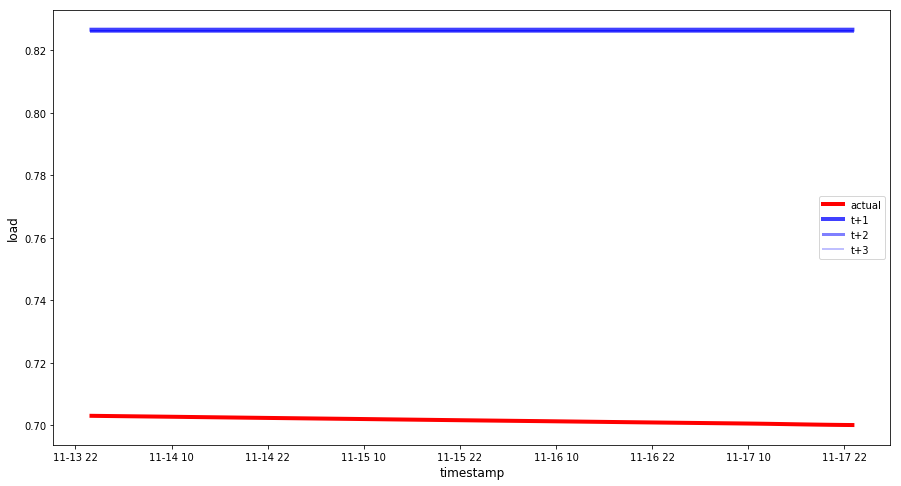

In [144]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [145]:
a = df.iloc[456:480  , :]
Actual = df.iloc[480:504,:]

In [146]:
new_df = pd.DataFrame()

In [147]:
columns = Paras[var_name] 

In [148]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [149]:
new_df = new_df.dropna( how = 'any')

In [150]:
new_df

,OMEGA
Epoch_Time_of_Clock,
2017-11-21 00:00:00,0.57766638179999996172
2017-11-21 01:00:00,0.57763870819999996176
2017-11-21 02:00:00,0.57761123219999999101
2017-11-21 03:00:00,0.57758394509999999578
2017-11-21 04:00:00,0.57755683189999995619
2017-11-21 05:00:00,0.57752972469999996896
2017-11-21 06:00:00,0.57750232619999997130
2017-11-21 07:00:00,0.57747486619999999213
2017-11-21 08:00:00,0.57744805460000003805


In [151]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 22)

In [152]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [153]:
date

DatetimeIndex(['2017-11-22 00:00:00', '2017-11-22 01:00:00',
               '2017-11-22 02:00:00', '2017-11-22 03:00:00',
               '2017-11-22 04:00:00', '2017-11-22 05:00:00',
               '2017-11-22 06:00:00', '2017-11-22 07:00:00',
               '2017-11-22 08:00:00', '2017-11-22 09:00:00',
               '2017-11-22 10:00:00', '2017-11-22 11:00:00',
               '2017-11-22 12:00:00', '2017-11-22 13:00:00',
               '2017-11-22 14:00:00', '2017-11-22 15:00:00',
               '2017-11-22 16:00:00', '2017-11-22 17:00:00',
               '2017-11-22 18:00:00', '2017-11-22 19:00:00',
               '2017-11-22 20:00:00', '2017-11-22 21:00:00',
               '2017-11-22 22:00:00', '2017-11-22 23:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='H')

In [154]:
new_df.index= date

In [155]:
new_df.columns

Index(['OMEGA'], dtype='object')

In [156]:
print(new_df)
print(new_df.columns)

                                     OMEGA
Epoch_Time_of_Clock                       
2017-11-22 00:00:00 0.57766638179999996172
2017-11-22 01:00:00 0.57763870819999996176
2017-11-22 02:00:00 0.57761123219999999101
2017-11-22 03:00:00 0.57758394509999999578
2017-11-22 04:00:00 0.57755683189999995619
2017-11-22 05:00:00 0.57752972469999996896
2017-11-22 06:00:00 0.57750232619999997130
2017-11-22 07:00:00 0.57747486619999999213
2017-11-22 08:00:00 0.57744805460000003805
2017-11-22 09:00:00 0.57742139459999997086
2017-11-22 10:00:00 0.57739322400000003821
2017-11-22 11:00:00 0.57736331850000000010
2017-11-22 12:00:00 0.57733291770000005894
2017-11-22 13:00:00 0.57730268709999998933
2017-11-22 14:00:00 0.57727265399999994067
2017-11-22 15:00:00 0.57724281779999997433
2017-11-22 16:00:00 0.57721317799999993792
2017-11-22 17:00:00 0.57718373400000000384
2017-11-22 18:00:00 0.57715448520000001142
2017-11-22 19:00:00 0.57712543119999992758
2017-11-22 20:00:00 0.57709657130000002745
2017-11-22 

In [157]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), [var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                      OMEGA
Epoch_Time_of_Clock                        
2017-11-22 00:00:00 -4.45537030569250003254
2017-11-22 01:00:00 -4.45573029579395729627
2017-11-22 02:00:00 -4.45608771542955306444
2017-11-22 03:00:00 -4.45644267777263358710
2017-11-22 04:00:00 -4.45679537794965607844


In [158]:
print(new_new_df)
print(inputs['X'])

tensor                                    X                          \
feature                               OMEGA                           
time step                              t-23                    t-22   
Epoch_Time_of_Clock                                                   
2017-11-22 23:00:00 -4.45537030569250003254 -4.45573029579395729627   

tensor                                                               \
feature                                                               
time step                              t-21                    t-20   
Epoch_Time_of_Clock                                                   
2017-11-22 23:00:00 -4.45608771542955306444 -4.45644267777263358710   

tensor                                                               \
feature                                                               
time step                              t-19                    t-18   
Epoch_Time_of_Clock                                                   
2017

In [159]:
predictions = model.predict(inputs['X'])

In [160]:
predictions

array([[-1.212027 , -1.2207781, -1.2215911, -1.2196908, -1.2214085,
        -1.2229817, -1.2243086, -1.2252584, -1.2259146, -1.2263553,
        -1.2266486, -1.2268431, -1.2269723, -1.2270588, -1.2271168,
        -1.2271563, -1.2271832, -1.227202 , -1.227215 , -1.2272242,
        -1.2272309, -1.2272357, -1.2272391, -1.2272416]], dtype=float32)

In [161]:
print(predictions.shape)


(1, 24)


In [162]:
results = predictions[-1, :]

In [163]:
results

array([-1.212027 , -1.2207781, -1.2215911, -1.2196908, -1.2214085,
       -1.2229817, -1.2243086, -1.2252584, -1.2259146, -1.2263553,
       -1.2266486, -1.2268431, -1.2269723, -1.2270588, -1.2271168,
       -1.2271563, -1.2271832, -1.227202 , -1.227215 , -1.2272242,
       -1.2272309, -1.2272357, -1.2272391, -1.2272416], dtype=float32)

In [164]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,OMEGA
0,-1.21202695369720458984
1,-1.22077810764312744141
2,-1.22159111499786376953
3,-1.21969079971313476562
4,-1.22140848636627197266
5,-1.22298169136047363281
6,-1.22430860996246337891
7,-1.22525835037231445312
8,-1.22591459751129150391
9,-1.22635531425476074219


In [165]:
res_df.index = date
res_df

,OMEGA
Epoch_Time_of_Clock,
2017-11-22 00:00:00,-1.21202695369720458984
2017-11-22 01:00:00,-1.22077810764312744141
2017-11-22 02:00:00,-1.22159111499786376953
2017-11-22 03:00:00,-1.21969079971313476562
2017-11-22 04:00:00,-1.22140848636627197266
2017-11-22 05:00:00,-1.22298169136047363281
2017-11-22 06:00:00,-1.22430860996246337891
2017-11-22 07:00:00,-1.22525835037231445312
2017-11-22 08:00:00,-1.22591459751129150391


In [166]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [167]:
# final generated ouput
res_df['actual'] = Actual
res_df

,OMEGA,actual
Epoch_Time_of_Clock,,
2017-11-22 00:00:00,0.82699263095855712891,0.57698306239999996858
2017-11-22 01:00:00,0.82631993293762207031,0.57695516499999999205
2017-11-22 02:00:00,0.82625740766525268555,0.57692745840000003721
2017-11-22 03:00:00,0.82640349864959716797,0.57689994210000006269
2017-11-22 04:00:00,0.82627147436141967773,0.57687261040000004098
2017-11-22 05:00:00,0.82615053653717041016,0.57684533709999996631
2017-11-22 06:00:00,0.82604849338531494141,0.57681789470000000009
2017-11-22 07:00:00,0.82597547769546508789,0.57679047259999993713
2017-11-22 08:00:00,0.82592505216598510742,0.57676363389999996123


In [168]:
res_df.to_csv('SA2OMEGA.csv')